In [1]:
!pip install wurlitzer
%load_ext wurlitzer
# Just so we can print inside a kernel

In [2]:
import numpy as np
from PIL import Image, ImageOps
from numba import cuda
import math
import timeit
import matplotlib.pyplot as plt


In [3]:
# @cuda.jit
# def noir_et_blanc(input, output):
#   x, y = cuda.grid(2)
#   if x < input.shape[0] and y < input.shape[1]:
#     R = input[x,y][0]
#     G = input[x,y][1]
#     B = input[x,y][2]
#     gris = 0.3 * R + 0.59 * G + 0.11 * B
#     output[x,y][0] = int(gris)
#     output[x,y][1] = int(gris)
#     output[x,y][2] = int(gris)

In [4]:
@cuda.jit
def gk_blur(sigma, kernel_size, kernel):
    c = kernel_size // 2
    x, y = cuda.grid(2)

    if x < kernel_size and y < kernel_size:
        exponent = -((x - c) ** 2 + (y - c) ** 2) / (2 * sigma ** 2)
        kernel[x, y] = np.int32(((1 / (2 * np.pi * sigma ** 2)) * math.exp(exponent)) * 1000)

In [5]:
@cuda.jit
def floute(input, output, kernel):
    x, y = cuda.grid(2)
    t_R, t_G, t_B = 0, 0, 0

    if x < input.shape[0] and y < input.shape[1]:
        R, G, B = input[x, y]

        centre = kernel.shape[0] // 2
        for i in range(-centre, centre + 1):
            for j in range(-centre, centre + 1):
                ni, nj = x + i, y + j
                ni_valid = 0 <= ni < input.shape[0]
                nj_valid = 0 <= nj < input.shape[1]

                pixel_value = input[ni, nj] if (ni_valid and nj_valid) else input[x, y]

                t_R += kernel[i + centre, j + centre] * pixel_value[0]
                t_G += kernel[i + centre, j + centre] * pixel_value[1]
                t_B += kernel[i + centre, j + centre] * pixel_value[2]

        output[x, y, 0] = t_R // 256
        output[x, y, 1] = t_G // 256
        output[x, y, 2] = t_B // 256

Thread Block Size (8, 8): Average Execution Time: 0.25793909850001456 seconds
Thread Block Size (16, 16): Average Execution Time: 0.27405679330000793 seconds


ERROR:numba.cuda.cudadrv.driver:Call to cuLaunchKernel results in CUDA_ERROR_INVALID_VALUE


Thread Block Size (32, 32): Average Execution Time: 0.4916452387000163 seconds
Error for Thread Block Size (64, 64): [1] Call to cuLaunchKernel results in CUDA_ERROR_INVALID_VALUE


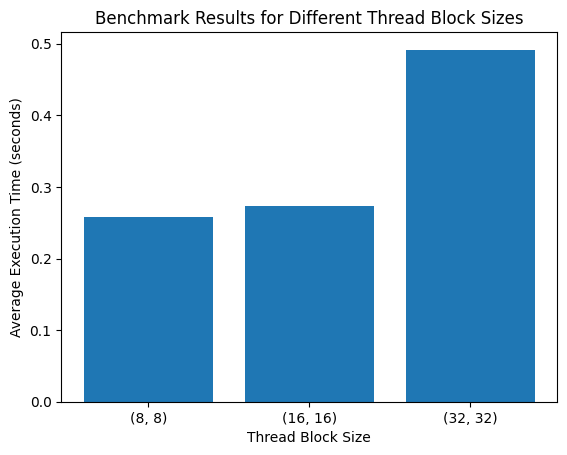

In [13]:
def Bench(image_source):
    image = np.asarray(image_source)
    d_image = cuda.to_device(image)
    d_result = cuda.device_array_like(image)
    sigma = 11.4
    kernel_size = 27

    # Define thread block sizes for the benchmark
    thread_block_sizes = [(8, 8), (16, 16), (32, 32), (64, 64)]

    # Store results for plotting
    avg_execution_times = []

    # Perform benchmark with different thread block sizes
    for tb_size in thread_block_sizes:
        execution_times = []

        try:
            for _ in range(11):  # Perform at least 11 experiments, discard the first value
                d_kernel = cuda.to_device(np.zeros((kernel_size, kernel_size), dtype=np.float32))
                gk_blur[(1,), (kernel_size, kernel_size)](sigma, kernel_size, d_kernel)

                # Measure execution time of floute kernel
                start_time = timeit.default_timer()
                floute[d_image.shape, tb_size](d_image, d_result, d_kernel)
                cuda.synchronize()
                end_time = timeit.default_timer()

                execution_time = end_time - start_time

                # Call the floute kernel
                floute[d_image.shape, tb_size](d_image, d_result, d_kernel)

                # Transfer the result back to the CPU (optional if not needed for display)
                result = d_result.copy_to_host()

                # Discard the first value (warm-up)
                if _ > 0:
                    execution_times.append(execution_time)

            # Calculate and store the average execution time
            avg_execution_time = np.mean(execution_times)
            avg_execution_times.append(avg_execution_time)
            print(f"Thread Block Size {tb_size}: Average Execution Time: {avg_execution_time} seconds")

        except cuda.cudadrv.driver.CudaAPIError as e:
            print(f"Error for Thread Block Size {tb_size}: {e}")
            avg_execution_times.append(np.nan)  # Use a placeholder value for cases where an error occurs

    # Plot the results
    thread_block_sizes_str = [str(tb) for tb in thread_block_sizes]
    plt.bar(thread_block_sizes_str, avg_execution_times)
    plt.xlabel('Thread Block Size')
    plt.ylabel('Average Execution Time (seconds)')
    plt.title('Benchmark Results for Different Thread Block Sizes')
    plt.show()

# Load the image
im = Image.open("test.jpg")
image = np.asarray(im)

# Call the benchmark function with your image
Bench(image)

In [7]:
# # Load the image
# im = Image.open("test.jpg")
# image = np.asarray(im)

# # Define Gaussian kernel parameters
# # sigma = 2.14
# # kernel_size = 2*math.ceil(3*sigma)+1
# sigma = 11.4
# kernel_size = 27

# # Create and blur the Gaussian kernel
# kernel = np.zeros((kernel_size, kernel_size), np.float32)
# d_kernel = cuda.to_device(kernel)
# gk_blur[(1,), (kernel_size, kernel_size)](sigma, kernel_size, d_kernel)

# gk  = d_kernel.copy_to_host()
# print(gk)

# # Apply the blurred kernel to the image
# d_image = cuda.to_device(image)
# d_result = cuda.device_array_like(image)

# # Define the thread block size
# tb = (16, 16)

# # Calculate the grid size based on the image dimensions and thread block size
# grid_x = math.ceil(image.shape[0] / tb[0])
# grid_y = math.ceil(image.shape[1] / tb[1])
# grid = (grid_x, grid_y)

# # Call the floute kernel
# floute[grid, tb](d_image, d_result, d_kernel)

# # Transfer the result back to the CPU
# result = d_result.copy_to_host()

# # Display the original and blurred images using matplotlib
# plt.figure()
# plt.imshow(image)
# plt.title("Original Image")

# plt.figure()
# plt.imshow(result)
# plt.title("Blurred Image")

# plt.show()

In [8]:
#